<a href="https://colab.research.google.com/github/alimoorreza/CS195-Fall24-Notebook-5/blob/main/cs195_part3_inference_using_trained_HRNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this task, you will evaluate the **HRNet model trained in Task 2** for its performance in semantic segmentation within an underwater environment. **[HRNet](https://arxiv.org/pdf/1908.07919) (*High Resolution Net*)** is a state-of-the-art semantic segmentation model, which has demonstrated superior performance compared to the widely recognized and commonly utilized models discussed in class, including:
* **FCN**
* **SegNet**
* **PSPNet**
* **U-Net**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##**Install the necessary libraries**

In [42]:
import torch
print(torch.__version__)

2.5.1+cu121


In [43]:
import torchvision
print(torchvision.__version__)

0.20.1+cu121


In [5]:
! pip install gdown

In [6]:
%%shell
pip install imagecodecs
pip install pickle5
pip install timm
pip install tensorboardX
pip install yacs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255316 sha256=1ee0fe4d1b660a2afee8aeb6e219cd275646983383c6d7cab46f3978b82eef87
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00


In [7]:
%%shell
[[ -d ./hrnetv2_sem_seg ]]
rm -rf ./hrnetv2_sem_seg
git clone https://github.com/alimoorreza/hrnetv2_sem_seg

Cloning into 'hrnetv2_sem_seg'...
remote: Enumerating objects: 2320, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 2320 (delta 182), reused 293 (delta 97), pack-reused 1866 (from 1)
Receiving objects: 100% (2320/2320), 181.28 MiB | 32.39 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (1975/1975), done.


In [8]:
%%shell
mkdir -p hrnetv2_sem_seg/log
mkdir -p hrnetv2_sem_seg/output
mkdir -p hrnetv2_sem_seg/init_model
mkdir -p hrnetv2_sem_seg/dataset

##**Download the [UWSv1 dataset](https://drive.google.com/uc?id=155Vg3iOTK3aed11LXC2lFQBxhdimfuZB)**
* This dataset comprises 574 images featuring 21 underwater animal categories and background objects such as *water and rock*. Pixel-wise annotations were provided by in-house annotators from Indiana University and Drake University, encompassing 29 total categories. The dataset is divided into training (461 images) and testing (113 images) sets using an 80:20 random split.

In [9]:
%%shell
gdown https://drive.google.com/uc?id=155Vg3iOTK3aed11LXC2lFQBxhdimfuZB

Downloading...
From (original): https://drive.google.com/uc?id=155Vg3iOTK3aed11LXC2lFQBxhdimfuZB
From (redirected): https://drive.google.com/uc?id=155Vg3iOTK3aed11LXC2lFQBxhdimfuZB&confirm=t&uuid=9f33094a-5806-4f27-8c50-233a7cc6faef
To: /content/uw_sem_seg_dataset.zip
100% 571M/571M [00:07<00:00, 75.3MB/s]


In [10]:
%%shell
unzip /content/uw_sem_seg_dataset.zip  -d hrnetv2_sem_seg/dataset

Archive:  /content/uw_sem_seg_dataset.zip
   creating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/
  inflating: hrnetv2_sem_seg/dataset/__MACOSX/._uw_sem_seg_dataset  
   creating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/train/
  inflating: hrnetv2_sem_seg/dataset/__MACOSX/uw_sem_seg_dataset/._train  
  inflating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/._train  
   creating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/validation/
  inflating: hrnetv2_sem_seg/dataset/__MACOSX/uw_sem_seg_dataset/._validation  
  inflating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/._validation  
   creating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/train/images/
  inflating: hrnetv2_sem_seg/dataset/__MACOSX/uw_sem_seg_dataset/train/._images  
  inflating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/train/._images  
   creating: hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/train/labels/
  inflating: hrnetv2_sem_seg/dataset/__MACOSX/uw_sem_seg_dataset/train/._labels  
  inflating: hrnetv2_sem_seg/dat

##**Download the pretrained weights for hrnet-v2**

In [12]:
%%shell
gdown https://drive.google.com/uc?id=1CHOKZcn6TnThoajYmfwjJ9g7Q4SRW4k4
mv hrnetv2_w48_imagenet_pretrained.pth hrnetv2_sem_seg/init_model/


Downloading...
From (original): https://drive.google.com/uc?id=1CHOKZcn6TnThoajYmfwjJ9g7Q4SRW4k4
From (redirected): https://drive.google.com/uc?id=1CHOKZcn6TnThoajYmfwjJ9g7Q4SRW4k4&confirm=t&uuid=de1818a0-0ebc-473b-85e2-fd9ee673e3fc
To: /content/hrnetv2_w48_imagenet_pretrained.pth
100% 311M/311M [00:02<00:00, 104MB/s]


##**Cleanup folder names such as .DS_store**

In [13]:
%%shell
find ./hrnetv2_sem_seg -name "._*" -delete
find ./hrnetv2_sem_seg/dataset/ -name "__MACOSX" -exec rm -rf {} +

##**Download your trained model**
> **Complete Task 2 to generate your best model (best.pth) and transfer it to the designated directory.**
>> /content/hrnetv2_sem_seg/output/

> **Ensure you complete training your model for Task 2, which generates the best.pth file. Upload this file to your Google Drive, copy its path, and use the gdown tool to download and place it in the designated location.**
>> /content/hrnetv2_sem_seg/output/

In [17]:
%%shell
gdown https://drive.google.com/uc?id=1iiTNxgFzEO9fJgMx3o3HIu47WZqYtfy3
mv best.pth /content/hrnetv2_sem_seg/output

# HEADS UP:
# The following Google Drive link should no longer work because I have stopped sharing it.

# gdown https://drive.google.com/uc?id=1iiTNxgFzEO9fJgMx3o3HIu47WZqYtfy3

# You need to complete Part 2 to obtain your `best.pth` model.


Downloading...
From (original): https://drive.google.com/uc?id=1iiTNxgFzEO9fJgMx3o3HIu47WZqYtfy3
From (redirected): https://drive.google.com/uc?id=1iiTNxgFzEO9fJgMx3o3HIu47WZqYtfy3&confirm=t&uuid=85391b89-8726-4c8a-b291-9c6ca5693954
To: /content/best.pth
100% 264M/264M [00:01<00:00, 153MB/s]


##__Run inference using the best-trained model on sample images from the validation split of the UWSv1 dataset.__

> With the necessary files prepared and the HRNet model trained on UWSv1 images, and after downloading the best-trained model to the designated directory (/content/hrnetv2_sem_seg/output), the next step involves applying a random image to the trained model. Observe the predictions to evaluate whether the model accurately predicts pixel-wise labels, which is referred to as **semantic segmentation.**

> You can apply the trained best.pth model to sample images from the validation set, which includes 113 images with annotated labels. Select three images randomly and apply them using HRNet.

In [18]:
# navigated to /content/hrnetv2_sem_seg by changing the directory
%cd hrnetv2_sem_seg

/content/hrnetv2_sem_seg


In [19]:
import argparse
import yaml

class DotDict(dict):
    """Custom dictionary supporting dot notation access."""
    def __getattr__(self, item):
        value = self.get(item)
        if isinstance(value, dict):
            return DotDict(value)  # recursively convert nested dictionaries
        return value

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        del self[key]

# ------------------------------------------------------------------
from config import config_hrnet_v2 as config # from config directory ('package' more precisely) loading 'default_hrnet_v2.py' as 'config_hrnet_v2' which is subsequently imported as 'config'
from config import update_config_hrnet_v2 as update_config
# ------------------------------------------------------------------

config_file_name = "/content/hrnetv2_sem_seg/experiments/hrnet/uws_training_hrnet_v2_train_COLAB.yaml"

try:
  with open(config_file_name) as file:
    config = yaml.safe_load(file)
    print(f"YAML file content loaded: {config}")
except FileNotFoundError:
  print(f"Error: File '{config_file_name}' not found.")

print(f"checking the values as dictionary keys: {config['CUDNN']}")
cfg = DotDict(config)
print(f"checking the values as dictionary keys: {cfg.CUDNN}")
print(f"checking the values as dictionary keys: {cfg.CUDNN.BENCHMARK}")
print(f"checking the values as dictionary keys: {cfg.MODEL.PRETRAINED}")
print(f"checking the values as dictionary keys: {cfg.LOSS.OHEMTHRES}")


YAML file content loaded: {'CUDNN': {'BENCHMARK': True, 'DETERMINISTIC': False, 'ENABLED': True}, 'GPUS': '(0,)', 'LOG_DIR': '/content/hrnetv2_sem_seg//log', 'OUTPUT_DIR': '/content/hrnetv2_sem_seg/output', 'WORKERS': 2, 'PRINT_FREQ': 100, 'DATASET': {'DATASET': 'UWS3', 'ROOT': '/content/hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/', 'TEST_SET': 'validation', 'TRAIN_SET': 'train', 'NUM_CLASSES': 29}, 'MODEL': {'NAME': 'seg_hrnet', 'NUM_OUTPUTS': 1, 'PRETRAINED': '/content/hrnetv2_sem_seg/init_model/hrnetv2_w48_imagenet_pretrained.pth', 'EXTRA': {'FINAL_CONV_KERNEL': 1, 'STAGE1': {'NUM_MODULES': 1, 'NUM_RANCHES': 1, 'BLOCK': 'BOTTLENECK', 'NUM_BLOCKS': [4], 'NUM_CHANNELS': [64], 'FUSE_METHOD': 'SUM'}, 'STAGE2': {'NUM_MODULES': 1, 'NUM_BRANCHES': 2, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4], 'NUM_CHANNELS': [48, 96], 'FUSE_METHOD': 'SUM'}, 'STAGE3': {'NUM_MODULES': 4, 'NUM_BRANCHES': 3, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4], 'NUM_CHANNELS': [48, 96, 192], 'FUSE_METHOD': 'SUM'}, 'STAGE4':

In [21]:
import torch

# for composing the transform for both 'image' as well as 'label'
from utils.hrnet_utils import transform
# import torchvision.transforms as transforms # HRNet doesn't do basic torchvision's transform which takes only one tensor (either the image or the label)

from utils.hrnet_v2_utils.utils import FullModel
from networks.hrnet_v2.seg_hrnet import HighResolutionNet
from core.criterion import CrossEntropy, OhemCrossEntropy
from torch.nn import functional as F


model = HighResolutionNet(cfg) # The HRNet model (HighResolutionNet)
model.init_weights(cfg.MODEL.PRETRAINED)
criterion = CrossEntropy(ignore_label=cfg.TRAIN.IGNORE_LABEL)

model = FullModel(model, criterion)

finetuned_model_state_file   = "/content/hrnetv2_sem_seg/output/best.pth"



np.sum(pre_stage_channels): [48, 96, 192, 384]


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
if (device == 'cpu'):
  pretrained_dict = torch.load(finetuned_model_state_file, map_location=torch.device('cpu'))
else:
  pretrained_dict = torch.load(finetuned_model_state_file)
model.load_state_dict(pretrained_dict)
model.to(device)
#print(model)


device =  cpu


<ipython-input-23-512ee1068e59>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(finetuned_model_state_file, map_location=torch.device('cpu'))


FullModel(
  (model): HighResolutionNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [25]:
# transform
import torch
#import torchvision.transforms as transform
from utils.hrnet_utils import transform  as custom_transform # we are using a different transform
from typing import Optional, Tuple
segmentation_label_dictionary = {
  0:  {'name': 'unlabeled',   'train_id': 255, 'color': (0,   0,   0)},
  1:  {'name': 'crab',        'train_id': 0,   'color': (128, 64,  128)},
  2:  {'name': 'crocodile',   'train_id': 1,   'color': (244, 35,  232)},
  3:  {'name': 'dolphin',     'train_id': 2,   'color': (70,  70,  70)},
  4:  {'name': 'frog',        'train_id': 3,   'color': (102, 102, 156)},
  5:  {'name': 'nettles',     'train_id': 4,   'color': (190, 153, 153)},
  6:  {'name': 'octopus',     'train_id': 5,   'color': (153, 153, 153)},
  7:  {'name': 'otter',       'train_id': 6,   'color': (250, 170, 30)},
  8:  {'name': 'penguin',     'train_id': 7,   'color': (220, 220, 0)},
  9:  {'name': 'polar_bear',  'train_id': 8,   'color': (107, 142, 35)},
  10: {'name': 'sea_anemone', 'train_id': 9,  'color': (152, 251, 152)},
  11: {'name': 'sea_urchin',  'train_id': 10,  'color': (70,  130, 180)},
  12: {'name': 'seahorse',    'train_id': 11,  'color': (220, 20,  60)},
  13: {'name': 'seal',        'train_id': 12,  'color': (253, 0,   0)},
  14: {'name': 'shark',       'train_id': 13,  'color': (0,   0,   142)},
  15: {'name': 'shrimp',      'train_id': 14,  'color': (0,   0,   70)},
  16: {'name': 'star_fish',   'train_id': 15,  'color': (0,   60,  100)},
  17: {'name': 'stingray',    'train_id': 16,  'color': (0,   80,  100)},
  18: {'name': 'squid',       'train_id': 17,  'color': (0,   0,   230)},
  19: {'name': 'turtle',      'train_id': 18,  'color': (119, 11,  32)},
  20: {'name': 'whale',       'train_id': 19,  'color': (111, 74,  0)},
  21: {'name': 'nudibranch',  'train_id': 20,  'color': (81,  0,   81)},
  22: {'name': 'coral',       'train_id': 21,  'color': (250, 170, 160)},
  23: {'name': 'rock',        'train_id': 22,  'color': (230, 150, 140)},
  24: {'name': 'water',       'train_id': 23,  'color': (180, 165, 180)},
  25: {'name': 'sand',        'train_id': 24,  'color': (150, 100, 100)},
  26: {'name': 'plant',       'train_id': 25,  'color': (150, 120, 90)},
  27: {'name': 'human',       'train_id': 26,  'color': (153, 153, 153)},
  28: {'name': 'reef',        'train_id': 27,  'color': (0,   0,   110)},
  29: {'name': 'others',      'train_id': 28,  'color': (47,  220, 70)}
}



def get_imagenet_mean_std() -> Tuple[Tuple[float,float,float], Tuple[float,float,float]]:
    """ See use here in Pytorch ImageNet script:
        https://github.com/pytorch/examples/blob/master/imagenet/main.py#L197

        Returns:
        -   mean: Tuple[float,float,float],
        -   std: Tuple[float,float,float] = None
    """
    value_scale = 255
    mean = [0.485, 0.456, 0.406]
    mean = [item * value_scale for item in mean]
    std = [0.229, 0.224, 0.225]
    std = [item * value_scale for item in std]
    return mean, std



# util function:
mean, std = get_imagenet_mean_std()

preprocess = custom_transform.Compose(
    [
            custom_transform.ResizeShort(cfg.TRAIN.IMAGE_SIZE[0]),
            custom_transform.Crop(
                [cfg.TRAIN.IMAGE_SIZE[0], cfg.TRAIN.IMAGE_SIZE[1]],
                crop_type="center",
                padding=mean,
                ignore_label=cfg.TRAIN.IGNORE_LABEL,
            ),
            custom_transform.ToTensor(),
            custom_transform.Normalize(mean=mean, std=std),
    ]
)


Text(0.5, 1.0, 'Input RGB image')

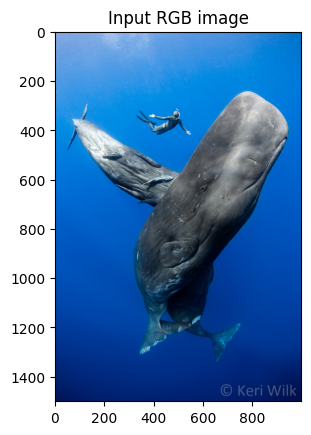

In [36]:
import PIL
import matplotlib.pyplot as plt
import numpy as np


img_name            = 'Whale_14.png'
img                 = PIL.Image.open('/content/hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/validation/images/' + img_name)
label               = PIL.Image.open('/content/hrnetv2_sem_seg/dataset/uw_sem_seg_dataset/validation/labels/' + img_name)

img_tensor, label_tensor = preprocess( np.array(img), np.array(label) )
plt.imshow(img)
plt.title('Input RGB image')


unique labels in this input image: [ 19  23  26 255]
label: whale
label: water
label: human
label: unlabeled


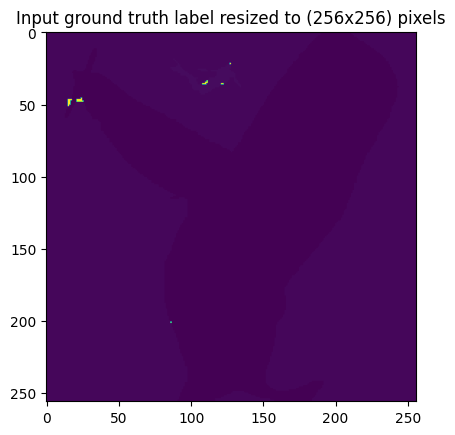

In [37]:
plt.imshow(label_tensor)
plt.title('Input ground truth label resized to (256x256) pixels')
# ---------- finding the label names from the map ---------------------
print(f"unique labels in this input image: {np.unique(label_tensor)}")

for id in np.unique(label_tensor):

  for key, val in segmentation_label_dictionary.items():
      if val['train_id'] == id:
        print(f"label: {val['name']}")

In [38]:
model.eval()
image_3d_tensor = img_tensor.to(device)
label           = label_tensor.long().to(device)
image           = image_3d_tensor.unsqueeze(0)
label           = label.unsqueeze(0)
losses, pred    = model(image, label)

size            = label.size()
if not isinstance(pred, (list, tuple)):
    pred = [pred]
for i, x in enumerate(pred):
    x = F.interpolate(
        input=x, size=size[-2:],
        mode='bilinear', align_corners=cfg.MODEL.ALIGN_CORNERS
    )

output    = x.cpu().detach().numpy().transpose(0, 2, 3, 1)
seg_pred  = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
seg_gt    = np.asarray( label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=np.int32 )

#ignore_index  = seg_gt != 255
#seg_gt        = seg_gt[ignore_index]
#seg_pred      = seg_pred[ignore_index]

print('np.unique(seg_gt): ', np.unique(seg_gt))
print('np.unique(seg_pred): ', np.unique(seg_pred))
seg_pred = seg_pred.squeeze(0)
seg_pred.shape



np.unique(seg_gt):  [ 19  23  26 255]
np.unique(seg_pred):  [ 4  6 13 19 23 26 28]


(256, 256)

unique labels in the predicted semantic segmentation: [ 4  6 13 19 23 26 28]
label: nettles
label: otter
label: shark
label: whale
label: water
label: human
label: others


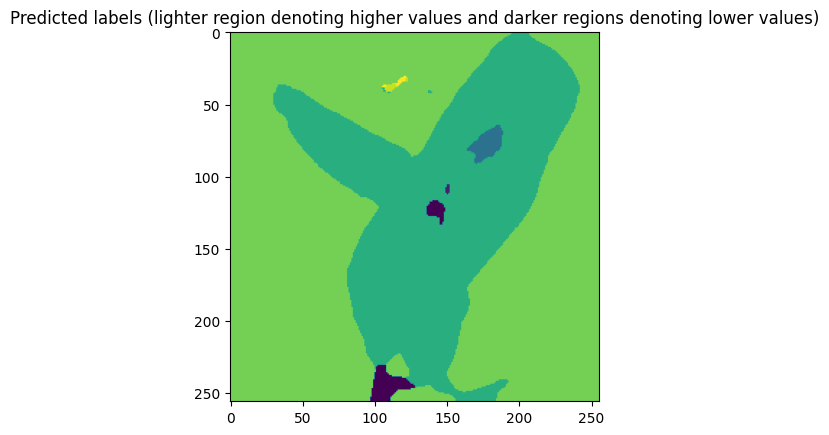

In [39]:
plt.imshow(seg_pred)
plt.title('Predicted labels (lighter region denoting higher values and darker regions denoting lower values)')
# ---------- finding the label names from the map ---------------------
print(f"unique labels in the predicted semantic segmentation: {np.unique(seg_pred)}")

for id in np.unique(seg_pred):

  for key, val in segmentation_label_dictionary.items():
      if val['train_id'] == id:
        print(f"label: {val['name']}")

In [41]:
from PIL import Image
import os
import numpy as np

def save_pred(pred, sv_path, name):
    color_img = np.zeros( (256, 256, 3) )
    for id in np.unique(pred):

      for key, val in segmentation_label_dictionary.items():
          if val['train_id'] == id:
            print(f"label: {val['name']}")
            cur_color = val['color']
            color_img[ pred == id] = cur_color

      save_img = Image.fromarray(color_img.astype(np.uint8))
      save_img.save(os.path.join(sv_path, name ))

sv_path = '/content/'
save_pred(seg_pred, sv_path, img_name)

label: nettles
label: otter
label: shark
label: whale
label: water
label: human
label: others


# __Task 3.1:__ (4 points)
### **Evaluating your trained HRNet semantic segmentation model on randomly selected images from UWSv1 dataset to assess its segmentation performance.**
* **Step 1:** Select three sample images from the validation partition of the UWSv1 dataset and perform inference using the trained HRNet model.

* **Step 2:** What are your overall observations regarding the predictions? Please provide your remarks. Are all the classes correctly predicted in these three images? Are there any false positive predictions? Please describe your observations in detail.
